In [1]:
# Import the libraries
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
from odc.stac import configure_rio, stac_load
import dask.distributed
import dask.utils
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# Set up Dask client for parallel processing
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)

# Configure rio with dynamic resolution
resolution = 20
memory_limit = dask.utils.parse_bytes(client.cluster.workers[0].memory_manager.memory_limit)
SHRINK = 4
if memory_limit < dask.utils.parse_bytes("4G"):
    SHRINK = 8  # Adjust chunk size if memory is limited

resolution = resolution * SHRINK


In [3]:
# Define the area of interest (AOI) for Lake Michigan
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-88.2, 43.0],  # Lower-left corner
            [-86.1, 43.0],  # Lower-right corner
            [-86.1, 45.0],  # Upper-right corner
            [-88.2, 45.0],  # Upper-left corner
            [-88.2, 43.0],  # Closing the polygon
        ]
    ],
}

#  time span of 1 month
time_of_interest = "2023-06-01/2023-07-01"

# Query the catalog for the data
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest
)
items = list(search.items())
print(f"Returned {len(items)} Items")


Returned 101 Items


In [4]:
# Load the data from the catalog with dynamic chunking and handle missing data
xx = stac_load(
    items,
    chunks={"x": 1024 * SHRINK, "y": 1024 * SHRINK},  # Dynamically adjust chunk size
    patch_url=planetary_computer.sign,
    resolution=resolution,
    dtype="uint16",  # Handle missing data by marking nodata values
    nodata=0
)

# Display loaded data
print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)


Bands: AOT,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,SCL,WVP,visual


<xarray.Dataset> Size: 9GB
Dimensions:      (y: 3874, x: 3873, time: 18)
Coordinates:
  * y            (y) float64 31kB 5e+06 5e+06 5e+06 ... 4.69e+06 4.69e+06
  * x            (x) float64 31kB 3e+05 3.001e+05 ... 6.097e+05 6.098e+05
    spatial_ref  int32 4B 32616
  * time         (time) datetime64[ns] 144B 2023-06-01T16:28:39.024000 ... 20...
Data variables: (12/16)
    AOT          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B01          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B02          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B03          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B04          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B05          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    ...           ...
    B11          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B12          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B8A          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    SCL          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    WVP          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    visual       (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>

In [5]:
# Function to convert data to float and handle missing nodata values
def to_float(xx, nodata_value=None):
    _xx = xx.astype("float32")  # Convert data to float32 for precision
    if nodata_value is None:
        nodata_value = _xx.attrs.pop("nodata", None)  # Fetch nodata value if exists
    if nodata_value is not None:
        return _xx.where(xx != nodata_value)  # Replace nodata with NaN
    return _xx

# Convert specific bands to float32 and handle missing data
b05 = to_float(xx.B05)  # Red-Edge band
b04 = to_float(xx.B04)  # Red band


In [6]:
# Calculate NDCI with small constant to avoid division by zero
ndci = (b05 - b04) / (b05 + b04 + 1e-6)

# Apply Min-Max normalization to scale NDCI between 0 and 1
ndci = (ndci - ndci.min()) / (ndci.max() - ndci.min())

# Display the calculated NDCI
display(ndci)


<xarray.DataArray (time: 18, y: 3874, x: 3873)> Size: 1GB
dask.array<truediv, shape=(18, 3874, 3873), dtype=float32, chunksize=(1, 3874, 3873), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 31kB 5e+06 5e+06 5e+06 ... 4.69e+06 4.69e+06
  * x            (x) float64 31kB 3e+05 3.001e+05 ... 6.097e+05 6.098e+05
    spatial_ref  int32 4B 32616
  * time         (time) datetime64[ns] 144B 2023-06-01T16:28:39.024000 ... 20...

In [28]:
ndci = ndci.fillna(ndci.mean())

In [29]:
chl = 826.57*(ndci**3) - 176.43*(ndci**2) + 19*(ndci) + 4.071
display(chl)

<xarray.DataArray (time: 18, y: 3874, x: 3873)> Size: 1GB
dask.array<add, shape=(18, 3874, 3873), dtype=float32, chunksize=(1, 3874, 3873), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 31kB 5e+06 5e+06 5e+06 ... 4.69e+06 4.69e+06
  * x            (x) float64 31kB 3e+05 3.001e+05 ... 6.097e+05 6.098e+05
    spatial_ref  int32 4B 32616
  * time         (time) datetime64[ns] 144B 2023-06-01T16:28:39.024000 ... 20...

In [25]:
print(chl.min().values, chl.max().values)

4.071 673.211


In [27]:
print(chl.values)

[[[       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ... 124.44884  134.16101         nan]
  [       nan        nan        nan ... 125.090775 150.3232          nan]
  ...
  [       nan        nan        nan ... 135.58665  133.32443         nan]
  [       nan        nan        nan ... 137.33961  111.56047         nan]
  [       nan        nan        nan ...        nan        nan        nan]]

 [[       nan        nan        nan ...        nan        nan        nan]
  [ 81.07416  101.3986    98.18106  ...        nan        nan        nan]
  [ 91.48515   89.15215   88.477936 ...        nan        nan        nan]
  ...
  [       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]]

 [[       nan        nan        nan ...        nan        nan        nan]
  [       nan        n

In [7]:
# # Efficient concatenation of NDCI across the time dimension
# ndci_comp = xr.concat([ndci.isel(time=i) for i in range(len(ndci))], dim="time").compute()

# # Display concatenated time series
# print(ndci_comp)
# #WRONG

In [ ]:
# import dask.array as da

# # Ensure ndci is a Dask array
# ndci = ndci.chunk({"time": 1, "x": 1024, "y": 1024})

# # Concatenate using Dask arrays
# ndci_comp = da.concatenate([ndci.isel(time=i).data for i in range(ndci.sizes["time"])], axis=0)

# # Reshape the concatenated array to include the time dimension
# ndci_comp = ndci_comp.reshape((ndci.sizes["time"], ndci.sizes["y"], ndci.sizes["x"]))

# # Convert back to xarray DataArray
# ndci_comp = xr.DataArray(ndci_comp, dims=("time", "y", "x"), coords={"time": ndci.time, "y": ndci.y, "x": ndci.x})

# # Display concatenated time series
# print(ndci_comp)

<xarray.DataArray 'reshape-ce1218b16809268ee35c6ceaffdefabf' (time: 18,
                                                              y: 3874, x: 3873)> Size: 1GB
dask.array<reshape, shape=(18, 3874, 3873), dtype=float32, chunksize=(1, 969, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 144B 2023-06-01T16:28:39.024000 ... 2023-0...
  * y        (y) float64 31kB 5e+06 5e+06 5e+06 ... 4.69e+06 4.69e+06 4.69e+06
  * x        (x) float64 31kB 3e+05 3.001e+05 3.002e+05 ... 6.097e+05 6.098e+05


In [19]:
pip install netCDF4

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# import numpy as np
# import xarray as xr
# import dask.distributed

# # Restart the Dask client
# client = dask.distributed.Client()
# client.restart()

# # Load the saved NetCDF file
# ndci_comp = xr.open_dataarray("ndci_comp.nc")





2024-12-03 19:58:15,541 - distributed.nanny - WARNING - Restarting worker
2024-12-03 19:58:15,543 - distributed.nanny - WARNING - Restarting worker
2024-12-03 19:58:15,550 - distributed.nanny - WARNING - Restarting worker
2024-12-03 19:58:15,558 - distributed.nanny - WARNING - Restarting worker


In [ ]:
# # Interpolate NaN values along the time dimension
# ndci_comp_interpolated = ndci.interpolate_na(dim="time", method="linear")

# # Convert the Dask array to a NumPy array
# ndci_comp_np = ndci_comp_interpolated.compute()


# ndci_rechunked = ndci.chunk(dict(time=-1))
# ndci_comp_interpolated = ndci_rechunked.interpolate_na(dim="time", method="linear")

In [ ]:
# import numpy as np
# import xarray as xr
# import dask.distributed

# # Restart the Dask client
# client = dask.distributed.Client()
# client.restart()

# # Convert the Dask array to a NumPy array
# ndci_comp_np = ndci_comp_interpolated.compute()

In [7]:
# Select a subset of coordinates (e.g., first 10 x and first 10 y coordinates)
ndci_subset = ndci[:, :10, :10]

In [30]:
chl_subset = chl[:, :10, :10]

In [8]:
client.close()

In [31]:
chl_values = chl_subset.values.reshape(-1, 1)
print(chl_values)

[[90.86055]
 [90.86055]
 [90.86055]
 ...
 [90.86055]
 [90.86055]
 [90.86055]]


In [32]:
display(chl_values)

array([[90.86055],
       [90.86055],
       [90.86055],
       ...,
       [90.86055],
       [90.86055],
       [90.86055]], dtype=float32)

In [36]:
print(chl_subset.shape)

(18, 10, 10)


In [ ]:
pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 10.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.9/29.9 MB 9.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.preprocessing import MinMaxScaler
ndci_subset = ndci_subset.fillna(ndci.mean()) #fill Nans with mean values
# Normalize the data
scaler = MinMaxScaler()
ndci_values = ndci_subset.values.reshape(-1, 1)


In [37]:
chl_scaled = scaler.fit_transform(chl_values).reshape(chl_subset.shape)

In [38]:
print(chl_scaled.shape)

(18, 10, 10)


In [39]:
display(chl_scaled)

array([[[0.20966792, 0.20966792, 0.20966792, ..., 0.20966792,
         0.20966792, 0.20966792],
        [0.20966792, 0.20966792, 0.20966792, ..., 0.20966792,
         0.20966792, 0.20966792],
        [0.20966792, 0.20966792, 0.20966792, ..., 0.20966792,
         0.20966792, 0.20966792],
        ...,
        [0.20966792, 0.20966792, 0.20966792, ..., 0.20966792,
         0.20966792, 0.20966792],
        [0.20966792, 0.20966792, 0.20966792, ..., 0.20966792,
         0.20966792, 0.20966792],
        [0.20966792, 0.20966792, 0.20966792, ..., 0.20966792,
         0.20966792, 0.20966792]],

       [[0.20966792, 0.20966792, 0.20966792, ..., 0.20966792,
         0.20966792, 0.20966792],
        [0.09510726, 0.33302748, 0.2953626 , ..., 0.15062892,
         0.20770824, 0.17709601],
        [0.2169795 , 0.18966913, 0.18177676, ..., 0.14119577,
         0.24424374, 0.21606493],
        ...,
        [0.13687569, 0.14611447, 0.18633533, ..., 0.15354419,
         0.24624789, 0.21713936],
        [0.1

In [40]:
# Define a function to prepare the time series data for LSTM
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Set time steps (e.g., using last 10 values to predict the next)
time_steps = 10
X, y = create_dataset(chl_scaled, time_steps)

# Reshape the input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], chl_subset.shape[1] * chl_subset.shape[2]))
y = np.reshape(y, (y.shape[0], chl_subset.shape[1] * chl_subset.shape[2]))

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (8, 10, 100), y shape: (8, 100)


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1]))

model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         5,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,500 (216.80 KB)

 Trainable params: 55,500 (216.80 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0516 - val_loss: 0.0157
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0563 - val_loss: 0.0146
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0531 - val_loss: 0.0133
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0483 - val_loss: 0.0120
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0469 - val_loss: 0.0107


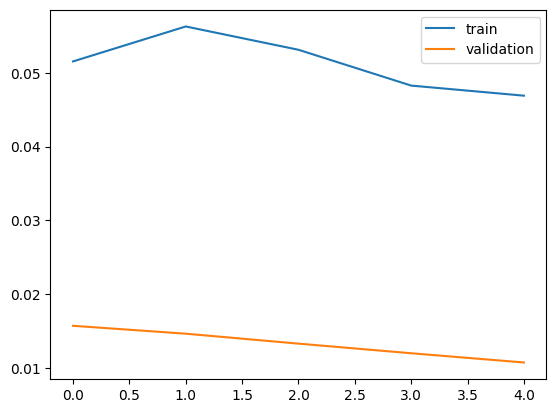

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0819
Model loss: 0.08193915337324142
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[ 0.20352517  0.03214688  0.19282646  0.09541622  0.14379506  0.30025578
   0.2298793   0.12297917  0.1031624   0.25742415  0.3127796   0.37271544
   0.37456897  0.39686882  0.20575957  0.30589575  0.31419495  0.16182002
   0.03833136  0.17714344  0.16452914  0.28564486  0.47326607  0.01965473
   0.13825214  0.24804632  0.19001468  0.31378132  0.13101214  0.21266311
   0.32287017  0.3139141   0.08670533  0.26023087  0.30934048  0.28564125
   0.3062662   0.2525013   0.16727595  0.11786266  0.24322973  0.15648168
   0.19632494  0.2595257   0.23289473  0.22605118  0.24411109  0.19112201
   0.31053588  0.25919533  0.20029618  0.01224315  0.17034414  0.24500677
   0.27054012  0.27284324  0.16688998  0.25827888  0.30301586  0.238767
   0.23983255  0.22687078  0.03194853  0.17020808  0.20850858  0.00975534
   0.3165624   0.36926398  0.13113363  0.22853082  0.11371559  0.

RasterioIOError: '/vsicurl/https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/16/T/CN/2023/06/07/S2B_MSIL2A_20230607T164849_N0509_R026_T16TCN_20230607T234053.SAFE/GRANULE/L2A_T16TCN_A032656_20230607T164859/IMG_DATA/R20m/T16TCN_20230607T164849_B05_20m.tif?st=2024-12-03T14%3A28%3A22Z&se=2024-12-04T15%3A13%3A22Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-12-04T14%3A26%3A35Z&ske=2024-12-11T14%3A26%3A35Z&sks=b&skv=2024-05-04&sig=fRoiTNule0jFl8ISCIlgYP4QON5l46pvjHEjpKrw/yo%3D' not recognized as a supported file format.

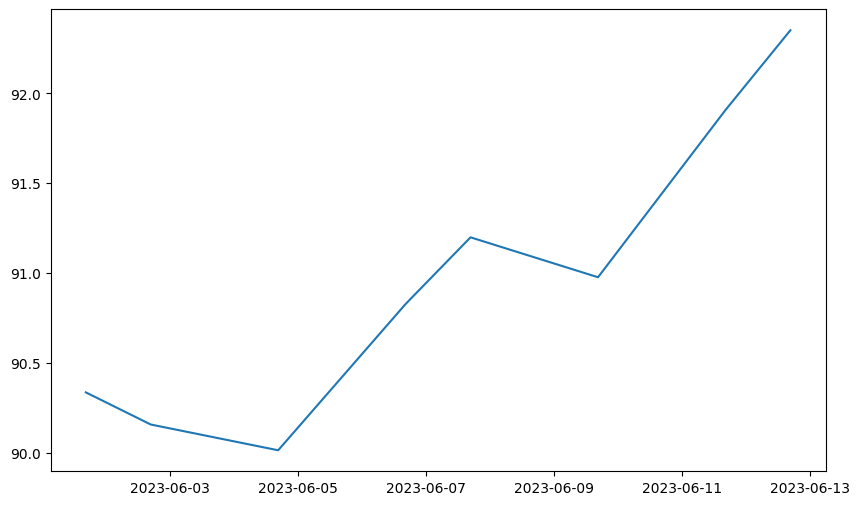

In [43]:
import matplotlib.pyplot as plt
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Model loss: {loss}")

# Make predictions
predictions = model.predict(X)
print(predictions)
# Reshape predictions to the original shape
predictions = predictions.reshape((predictions.shape[0], chl_subset.shape[1], chl_subset.shape[2]))

# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape)

# Plot some predictions
plt.figure(figsize=(10, 6))
plt.plot(chl.coords['time'].values[:len(predictions)], predictions[:, 0, 0], label='Predicted')
plt.plot(chl.coords['time'].values[:len(predictions)], chl_subset[:len(predictions), 0, 0], label='Actual')
plt.legend()
plt.show()

In [ ]:
# Check for NaN or infinite values in the data
if np.isnan(ndci_comp_np_subset).any() or np.isinf(ndci_comp_np_subset).any():
    raise ValueError("Input data contains NaN or infinite values.")


ValueError: Input data contains NaN or infinite values.